## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency

## Connect to database

In [2]:
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [4]:
#make sure to change input to connection to ur postgres account 
conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres"
#     , password= [your password], 
#     port = "5431" [change your port if needed] 
)
conn.autocommit = True
cursor = conn.cursor()

In [5]:
sql = """
SELECT * FROM ELIXHAUSER_MATCH;
"""

In [6]:
all_data = pd.read_sql_query(sql, conn)

/var/folders/07/9pcptmds0fl8q4v1tqm04jph0000gn/T/ipykernel_9335/2844448536.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_data = pd.read_sql_query(sql, conn)


In [7]:
# Assuming you have a DataFrame named 'cardiopulmanary' and you want to drop the first 4 columns
elix_final_df = all_data.drop(all_data.columns[:5], axis=1)
elix_final_df.head()

,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,...,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## List of Elixhauser conditions by patient

In [4]:
# Method to turn one_hot encoded columns into a column with a list of diseases
def get_one_hot_columns(row):
    return row[row == 1].index.tolist()

In [9]:
elix_final_df['categories'] = elix_final_df.apply(get_one_hot_columns, axis=1)
elix_final_df['categories']

0        [hypertension, diabetes_complicated, renal_fai...
1                            [hypertension, liver_disease]
2        [cardiac_arrhythmias, lymphoma, fluid_electrol...
3                                           [hypertension]
4        [cardiac_arrhythmias, peripheral_vascular, hyp...
                               ...                        
37279    [peripheral_vascular, hypothyroidism, fluid_el...
37280    [cardiac_arrhythmias, valvular_disease, fluid_...
37281    [valvular_disease, peripheral_vascular, alcoho...
37282    [cardiac_arrhythmias, peripheral_vascular, hyp...
37283                                  [fluid_electrolyte]
Name: categories, Length: 37284, dtype: object

In [10]:
disease_frequency = elix_final_df['categories'].explode().value_counts()
disease_proportion = disease_frequency/elix_final_df.shape[0]
disease_proportion

categories
hypertension              0.534036
cardiac_arrhythmias       0.339475
fluid_electrolyte         0.281837
chronic_pulmonary         0.199388
diabetes_uncomplicated    0.191476
renal_failure             0.121366
valvular_disease          0.109028
other_neurological        0.103315
coagulopathy              0.103208
hypothyroidism            0.095161
depression                0.092131
liver_disease             0.090360
alcohol_abuse             0.084943
peripheral_vascular       0.076413
pulmonary_circulation     0.058712
diabetes_complicated      0.054366
metastatic_cancer         0.054125
obesity                   0.049995
drug_abuse                0.041761
weight_loss               0.037335
rheumatoid_arthritis      0.030576
solid_tumor               0.028109
paralysis                 0.027036
deficiency_anemias        0.025158
blood_loss_anemia         0.018319
psychoses                 0.015288
lymphoma                  0.012740
peptic_ulcer              0.008368
aids     

In [11]:
disease_frequency['hypertension']

19911

## Visualizing the Network

### Population with RR

In [12]:
# Method to return a dictionary with all edges
def build_edge_dict(df, row, e_dict, pop):
    PAIR=2

    for disease_pair in combinations(row, PAIR):
        edge = frozenset({disease_pair[0], disease_pair[1]})
        denom = df[disease_pair[0]]*df[disease_pair[1]]
        numer = (1/pop)
        
        if edge in e_dict:
            e_dict[edge]['weight'] += numer/denom
            e_dict[edge]['occurrences'] += 1
        else:
            e_dict[edge] = {'weight': numer/denom, 'occurrences': 1}

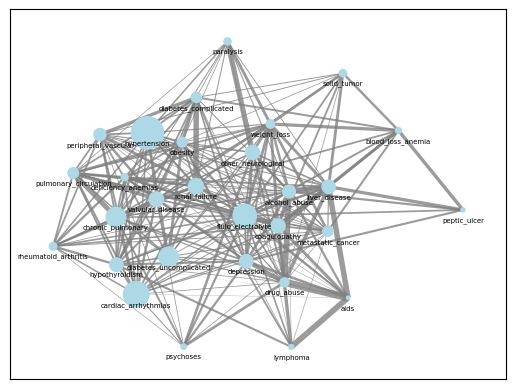

In [13]:
NODE_SCALE = 1000
EDGE_SCALE = 1
SPRING_CONST = 0.2
ALPHA_CONST = 0.5
FONT_SIZE = 5
TOTAL_POP = elix_final_df.shape[0]
edge_dict = {}

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in disease_proportion.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Building the edge_dict
elix_final_df['categories'].apply(lambda row: build_edge_dict(disease_proportion, row, edge_dict, elix_final_df.shape[0]))

# Adding edges based on edge_dict
for edge, attrs in edge_dict.items():
    node1, node2 = edge
    
    # Only adding significant edges
    cont_table = [[attrs['occurrences'], disease_frequency[node1]], [disease_frequency[node2], TOTAL_POP]]
    chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
    if p_value < 0.05:
        G.add_edge(node1, node2, **attrs)
        
max_weight = max([d['weight'] for (u, v, d) in G.edges(data=True)])
min_weight = min([d['weight'] for (u, v, d) in G.edges(data=True)])
        
for (u, v, d) in G.edges(data=True):
    d['style'] = 'dashed' if d['weight'] < 1 else 'solid'
    d['weight_normalized'] = (d['weight'] - min_weight) / (max_weight - min_weight)
    d['alpha'] = d['weight_normalized'] * 0.9 + 0.1

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=d['alpha'], width=edge_weights, edge_color='grey', style=d['style'])

# Offset for label positions
label_offset = 0.05
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

In [14]:
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
weights

[1.349664715433131,
 1.54644308609785,
 0.7609074987434146,
 1.1513036282372737,
 1.3362088884162706,
 1.3565960905917662,
 1.3019326561137265,
 1.1010009068198527,
 0.935293135534255,
 0.7166118466201976,
 0.5941112323635914,
 1.1520798179203766,
 1.1616247543960252,
 0.8277003129734978,
 0.8326851904769256,
 1.1220335253784084,
 1.128447380316101,
 0.6002856250986756,
 1.0927315686202759,
 0.7983892096922077,
 1.3679150071660153,
 1.1561720551188617,
 1.2259971816135684,
 1.3957187623994975,
 1.7225044438165784,
 0.6758809442450151,
 1.1130663728435846,
 1.1556776103230872,
 0.5487767046589559,
 0.5486572274581908,
 0.7897103362930975,
 1.1806133898483253,
 1.476225099727812,
 1.1421131639242612,
 0.7751899302653422,
 0.22550979789537184,
 1.2101071865045177,
 1.271550891564456,
 1.3204477177801717,
 1.1493078182025325,
 1.3215866352396552,
 1.5000261205879566,
 1.1497236522020582,
 1.3650996659421262,
 1.6577008197290413,
 1.7344275661272495,
 1.3029690100940081,
 1.1850513636681719

### Subgroups with Disease Prevalence

In [5]:
#make sure that processed data contains the subgroups from LCA and make sure they match up according to the LCA provided! 
cardiopulmanary = pd.read_csv('../processed_data/subgroup_4.csv')
young = pd.read_csv('../processed_data/subgroup_3.csv')
hepatic_addiction = pd.read_csv('../processed_data/subgroup_7.csv')
complicated_diabetes = pd.read_csv('../processed_data/subgroup_6.csv')
uncomplicated_diabetes = pd.read_csv('../processed_data/subgroup_1.csv')
cardiac = pd.read_csv('../processed_data/subgroup_2.csv')

cardiopulmanary = cardiopulmanary.iloc[:, 5:-3]
cardiopulmanary['categories'] = cardiopulmanary.apply(get_one_hot_columns, axis=1)
young = young.iloc[:, 5:-3]
young['categories'] = young.apply(get_one_hot_columns, axis=1)
hepatic_addiction = hepatic_addiction.iloc[:, 5:-3]
hepatic_addiction['categories'] = hepatic_addiction.apply(get_one_hot_columns, axis=1)
complicated_diabetes = complicated_diabetes.iloc[:, 5:-3]
complicated_diabetes['categories'] = complicated_diabetes.apply(get_one_hot_columns, axis=1)
uncomplicated_diabetes = uncomplicated_diabetes.iloc[:, 5:-3]
uncomplicated_diabetes['categories'] = uncomplicated_diabetes.apply(get_one_hot_columns, axis=1)
cardiac = cardiac.iloc[:, 5:-3]
cardiac['categories'] = cardiac.apply(get_one_hot_columns, axis=1)

cardiac.head()

,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,...,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,categories
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[cardiac_arrhythmias, coagulopathy]"
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[cardiac_arrhythmias, valvular_disease, hypert..."
2,1,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[cardiac_arrhythmias, peripheral_vascular, hyp..."
3,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,"[cardiac_arrhythmias, hypertension, other_neur..."
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[cardiac_arrhythmias, hypertension, renal_fail..."


In [6]:
df_cardiopulmanary = cardiopulmanary['categories'].explode().value_counts()
df_cardiopulmanary = df_cardiopulmanary/cardiopulmanary.shape[0]
df_young = young['categories'].explode().value_counts()
df_young = df_young/young.shape[0]
df_hepatic_addiction = hepatic_addiction['categories'].explode().value_counts()
df_hepatic_addiction = df_hepatic_addiction/hepatic_addiction.shape[0]
df_complicated_diabetes = complicated_diabetes['categories'].explode().value_counts()
df_complicated_diabetes = df_complicated_diabetes/complicated_diabetes.shape[0]
df_uncomplicated_diabetes = uncomplicated_diabetes['categories'].explode().value_counts()
df_uncomplicated_diabetes = df_uncomplicated_diabetes/uncomplicated_diabetes.shape[0]
df_cardiac = cardiac['categories'].explode().value_counts()
df_cardiac = df_cardiac/cardiac.shape[0]

df_cardiopulmanary

chronic_pulmonary         0.927916
pulmonary_circulation     0.671035
hypertension              0.659240
cardiac_arrhythmias       0.631717
valvular_disease          0.380516
fluid_electrolyte         0.353429
diabetes_uncomplicated    0.286151
renal_failure             0.266055
peripheral_vascular       0.147663
hypothyroidism            0.144168
obesity                   0.143731
coagulopathy              0.142857
depression                0.121014
other_neurological        0.075142
diabetes_complicated      0.066405
liver_disease             0.061599
deficiency_anemias        0.054609
rheumatoid_arthritis      0.054609
alcohol_abuse             0.047182
weight_loss               0.039755
metastatic_cancer         0.034076
drug_abuse                0.026212
blood_loss_anemia         0.017912
solid_tumor               0.017912
psychoses                 0.015727
lymphoma                  0.011796
paralysis                 0.009174
peptic_ulcer              0.006116
aids                

In [7]:
# Method to add edges row by row for subgroups
def add_edges_from_row(graph, row):
    for disease_pair in combinations(row, 2):
        if graph.has_edge(*disease_pair):
            graph[disease_pair[0]][disease_pair[1]]['weight'] += 1
        else:
            graph.add_edge(disease_pair[0], disease_pair[1], weight=1)

### Young Subgroup

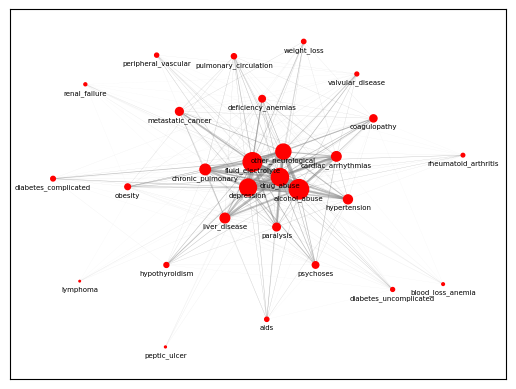

In [18]:
NODE_SCALE = 1000
EDGE_SCALE = 0.025
SPRING_CONST = 4
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_young.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
young['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='red')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

### Cardiopulmonary subgroup

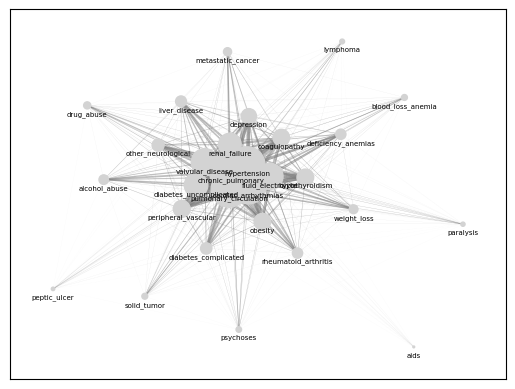

In [19]:
NODE_SCALE = 1000
EDGE_SCALE = 0.0125
SPRING_CONST = 5
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_cardiopulmanary.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
cardiopulmanary['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightgrey')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

### Complicated Diabetes Subgroup

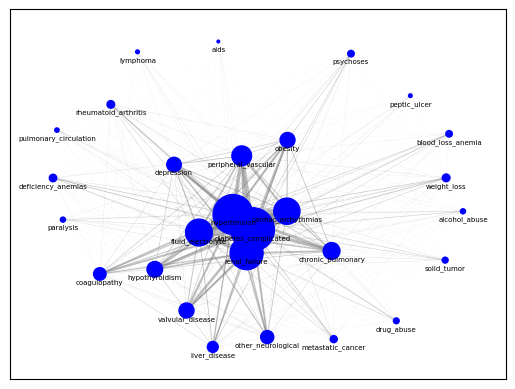

In [21]:
NODE_SCALE = 1000
EDGE_SCALE = 0.01
SPRING_CONST = 8
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_complicated_diabetes.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
complicated_diabetes['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='blue')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

### Uncomplicated Diabetes Subgroup

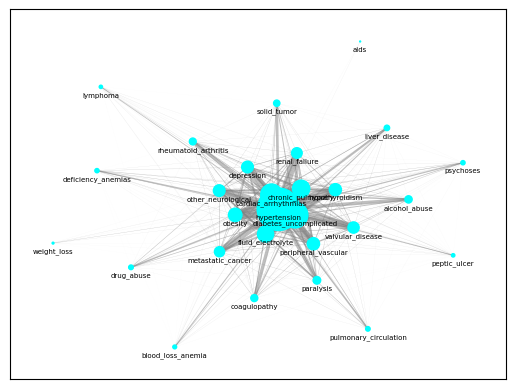

In [22]:
NODE_SCALE = 1000
EDGE_SCALE = 0.01
SPRING_CONST = 6
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_uncomplicated_diabetes.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
uncomplicated_diabetes['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='cyan')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

### Hepatic Addiction Subgroup

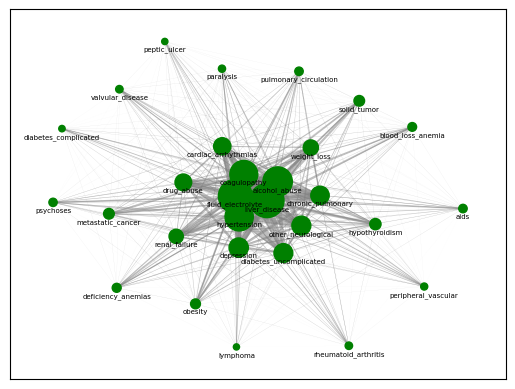

In [23]:
NODE_SCALE = 1000
EDGE_SCALE = 0.01
SPRING_CONST = 8
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_hepatic_addiction.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
hepatic_addiction['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='green')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()

### Cardiac Subgroup

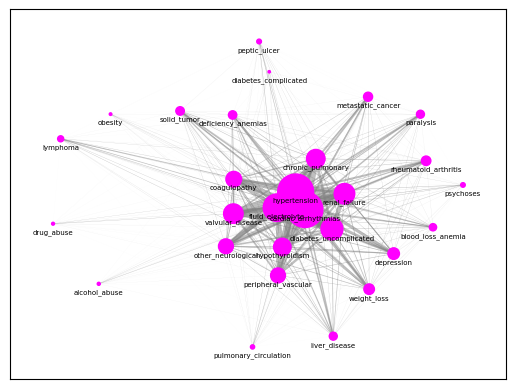

In [24]:
NODE_SCALE = 1000
EDGE_SCALE = 0.005
SPRING_CONST = 10
ALPHA_CONST = 0.5
FONT_SIZE = 5

# Graphing the network
G = nx.Graph()

# Adding nodes
for disease, freq in df_cardiac.items():
    G.add_node(disease, size=freq*NODE_SCALE)
    
# Adding nodes
cardiac['categories'].apply(lambda row: add_edges_from_row(G, row))

# Graph params
pos = nx.spring_layout(G, k=SPRING_CONST)
sizes = [G.nodes[node]['size'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='magenta')
edge_weights = [G[u][v]['weight']*EDGE_SCALE for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, alpha=ALPHA_CONST, width=edge_weights, edge_color='grey')
# Offset for label positions
label_offset = 0.05  # Adjust this value as needed
label_pos = {node: (position[0], position[1]-label_offset) for node, position in pos.items()}

# Draw labels with offset
nx.draw_networkx_labels(G, label_pos, font_size=FONT_SIZE)
plt.show()